## Image Preparation For Convolutional Neural Networks With TensorFlow's Keras API


### Build and Train a CNN with TensorFlow's Keras API

#### Obtain The Data
The first thing we need to do is get and prepare the data for which we'll be training the CNN.

The data set we'll use is a random subset of the data set from the Kaggle Dogs Versus Cats competition. You can download the data [here](https://kaggle.com/c/dogs-vs-cats/data).

#### Organize The Data
We now need to organize the directory structure on disk to hold the data set. We'll manually do some parts of the organization, and programmatically do the rest.

Copy the downloaded dogs-vs-cats.zip file, and paste it into whichever directory you'd like to work from. Relative to the Jupyter notebook we'll be working in, I'm placing dogs-vs-cats.zip within a directory called data.

Now, extract dogs-vs-cats.zip, and then extract train.zip from within. We won't be working with the provided test set for the moment, so you can move the test1.zip elsewhere if you'd like.

Next, select all of the image files from within the train directory and move them into the base dogs-vs-cats directory. Lastly, delete the empty train directory.

That's it for the manual labor! At this point, we have 25,000 labeled images of cats and dogs in our dogs-vs-cats directory. Note, the labels are included in the file names. Now, we'll do the remainder of the data organization programmatically.


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("num GPUs available :", len(physical_devices))
#enable memory growth
tf.config.experimental.set_memory_growth(physical_devices[0],True)

num GPUs available : 1


### Data Preparation

Using the script below, we'll organize our data into train, validation, and test sets. We'll do this by moving subsets of the data into sub-directories for each separate data set.

In [4]:
# Organize data into train, valid, test dirs
os.chdir('data/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../..')


We then create variables for which the the paths to the train, valid, and test data directories are assigned.

We can either specify an absolute path or a relative path relative to where our Jupyter notebook resides. I'm specifying the relative path.


In [5]:
train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'


Now, we use Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories.

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


### Visualize The Data
We now call next(train_batches) to generate a batch of images and labels from the training set. Note that the size of
this batch is determined by the batch_size we set when we created train_batches.



In [7]:
imgs, labels = next(train_batches)

We then use this plotting function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.



In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

This is what the first processed random batch from the training set looks like, the color appears to be distorted. This has to do with the VGG16 processing we applied to the data sets,the RGB pixel data has been processed in such a way that the image data now looks like this before being passed to the network.

Dogs are represented with the one-hot encoding of [0,1], and cats are represented by [1,0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

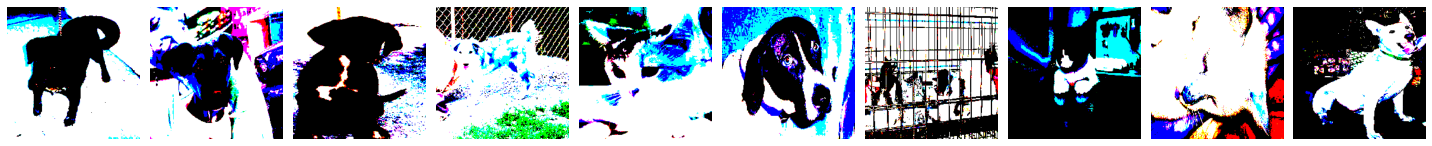

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [9]:
plotImages(imgs)
print(labels)




We'll use this data to train a convolutional neural network.
To build the CNN, we'll use a Keras Sequential model.

In [10]:
model =Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2),strides=2),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2),strides=2),
           Flatten(),
           Dense(units=2, activation='softmax'),
])

The first layer in the model is a 2-dimensional convolutional layer. This layer will have 32 output filters each with a kernel size of 3x3, and we'll use the relu activation function.

The choice for the number of output filters specified is arbitrary, and the chosen kernel size of 3x3 is generally a very common size to use. Y

We enable zero-padding by specifying padding = 'same'.

On the first layer only, we also specify the input_shape, which is the shape of our data. Our images are 224 pixels high and 224 pixels wide and have 3 color channels: RGB. This gives us an input_shape of (224,224,3).

We then add a max pooling layer to pool and reduce the dimensionality of the data.

We follow this by adding another convolutional layer with the exact specs as the earlier one, except for this second Conv2D layer has 64 filters. The choice of 64 here is again arbitrary, but the general choice of having more filters in later layers than in earlier ones is common. This layer is again followed by the same type of MaxPool2D layer.

We then Flatten the output from the convolutional layer and pass it to a Dense layer. This Dense layer is the output layer of the network, and so it has 2 nodes, one for cat and one for dog. We'll use the softmax activation function on our output so that the output for each sample is a probability distribution over the outputs of cat and dog.

We can check out a summary of the model by calling model.summary().

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
__________________________________________________

Now that the model is built, we compile the model using the Adam optimizer with a learning rate of 0.0001, a loss of categorical_cross_entropy, and we'll look at accuracy as our performance metric. 

Note that when we have only two classes, we could instead configure our output layer to have only one output, rather than two, and use binary_crossentropy as our loss, rather than categorical_crossentropy. Both options work equally well and achieve the exact same result.

With binary_crossentropy, however, the last layer would need to use sigmoid, rather than softmax, as its activation function.

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



#### Train A Simple CNN
Now it's time to train the model.

We'll be using the model.fit() function to train a model, except for now, we'll be passing in our newly introduced DirectoryIterators train_batches and valid_batches to train and validate the model. 



We need to specify steps_per_epoch to indicate how many batches of samples from our training set should be passed to the model before declaring one epoch complete. Since we have 1000 samples in our training set, and our batch size is 10, then we set steps_per_epoch to be 100, since 100 batches of 10 samples each will encompass our entire training set.

We're able to use len(train_batches) as a more general way to specify this value, as the length of train_batches is equal to 100 since it is made up of 100 batches of 10 samples. Similarly, we specify validation_steps in the same fashion but with using valid_batches.

We're specifying 10 as the number of epochs we'd like to run, and setting the verbose parameter to 2, which just specifies the verbosity of the log output printed to the console during training.

When we run this line of code, we can see the output of the model over 10 epochs.

In [13]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 26s - loss: 13.2211 - accuracy: 0.5740 - val_loss: 8.0258 - val_accuracy: 0.5450
Epoch 2/10
100/100 - 6s - loss: 1.6281 - accuracy: 0.7900 - val_loss: 2.9341 - val_accuracy: 0.6350
Epoch 3/10
100/100 - 6s - loss: 0.3615 - accuracy: 0.9100 - val_loss: 3.3924 - val_accuracy: 0.5550
Epoch 4/10
100/100 - 6s - loss: 0.1179 - accuracy: 0.9650 - val_loss: 2.5951 - val_accuracy: 0.6250
Epoch 5/10
100/100 - 6s - loss: 0.0241 - accuracy: 0.9890 - val_loss: 2.3420 - val_accuracy: 0.6600
Epoch 6/10
100/100 - 6s - loss: 0.0092 - accuracy: 0.9980 - val_loss: 2.2474 - val_accuracy: 0.6600
Epoch 7/10
100/100 - 6s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.2626 - val_accuracy: 0.6450
Epoch 8/10
100/100 - 6s - loss: 8.9418e-04 - accuracy: 1.0000 - val_loss: 2.2204 - val_accuracy: 0.6850
Epoch 9/10
100/100 - 6s - loss: 4.8846e-04 - accuracy: 1.0000 - val_loss: 2.2729 - val_accuracy: 0.6500
Epoch 10/10
100/100 - 6s - loss: 3.5031e-04 - accuracy: 1.0000 - val_loss: 2.2752 - val_ac

From this output, we can see the performance of this simple model on the training set is great, with accuracy reaching 100% and loss nearing 0, however, by comparing these results to the validation metrics, we can see that our model is vastly overfitting to the training data.

At this point, we could continue to work on this model to combat overfitting, or we could try another approach of using a pre-trained model on this data. 



### CNN Predictions with Keras

#### Preparing The Test Data

We'll now run next(test_batches) to extract a batch of images and their corresponding labels from the test set.

"test_batches"  was created using Keras ImageDataGenerator.flow_from_directory() to generate batches of data from the test set that resides on disk.

Using the plotImages() function we previously introduced, we can see what this batch of test data looks like.

Just as we saw before, cats are labeled with a one-hot encoding of [1,0], and dogs are labeled as [0,1].

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

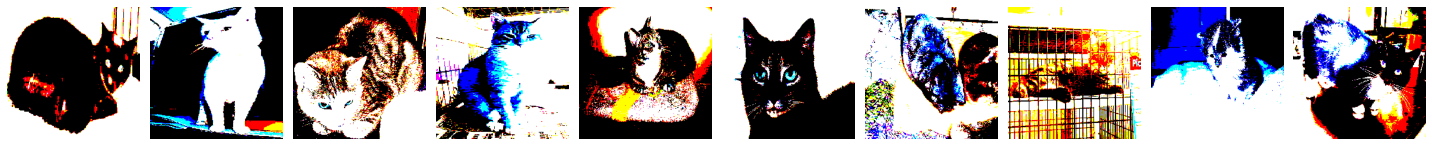

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [14]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

Note, because we chose to not shuffle our test set when we originally created it, the first half of the test data is all cats, and the second half is all dogs. Also, recall that the color data appears skewed due to the VGG16 preprocessing we specified when we created the data sets.


In [15]:
#These are the labels that the model is predicting for our images.
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Predicting On The Test Data
Now we'll use our previously built model and call model.predict() to have the model predict on the test set.
We pass in the test set, test_batches, and set steps to be then length of test_batches, steps specifies how many batches to yield from the test set before declaring one prediction round complete.

We also specify verbose=0 to see no output during the evaluation process.

In [16]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

After running the predictions, we can print our the rounded predictions see what they look like.

In [17]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.

#### Plotting Predictions With A Confusion Matrix
To get a better visualization of these results, we'll plot them in a confusion matrix.

To the confusion matrix, we pass the true labels of the test set, along with the predicted labels for the test set from the model.

In [18]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [19]:
cm

array([[27, 23],
       [29, 21]], dtype=int64)

In [20]:
#we can access the unshuffled true labels for the test set by calling test_batches.classes.
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

We transform the one-hot encoded predicted labels to be in the same format as the true labels by only selecting the element with the highest value for each prediction using np.argmax(predictions, axis=-1).

We then define the plot_confusion_matrix() function that is copied directly from scikit-learn.

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

We can then inspect the class_indices for the labels so that we know in which order to pass them to our confusion matrix.



In [22]:
test_batches.class_indices


{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[27 23]
 [29 21]]


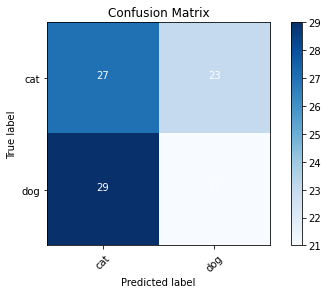

In [23]:
#Finally, we plot the confusion matrix.

cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

We can see that the model correctly predicted that an image was a cat 26 times when it actually was a cat, and it incorrectly predicted that an image was a cat 15 times when it was not a cat. It correctly predicted that an image was a dog 25 times, and incorrectly predicted that an image was a dog 25 times.

Given what we saw last time from the validation metrics, these results are not surprising.

Now that we have a general understanding for how to build and work with a CNN using Keras, we'll now move on to working with a pre-trained model on this data set, which we will see will generalize much better!

### Build a Fine-Tuned Neural Network with  Keras 

### Train a Fine-Tuned Neural Network with Keras



### Predict with a Fine-Tuned Neural Network with Keras

### MobileNet Image Classification with Keras
we'll introduce MobileNets, a class of light weight deep convolutional neural networks that are vastly smaller in size and faster in performance than many other popular models. We'll also see how we can work with MobileNets in code using TensorFlow's Keras API.


MobileNets are a class of small, low-latency, low-power models that can be used for classification, detection, and other common tasks convolutional neural networks are good for. Because of their small size, these are considered great deep learning models to be used on mobile devices.

Comparing MobileNets To Other Models
To give a quick comparison in regards to size, the size of the full VGG16 network on disk is about 553 megabytes. The size of one of the currently largest MobileNets is about 17 megabytes, so that is a huge difference, especially when you think about deploying a model to a mobile app or running it in the browser.

Model	Size	Parameters
VGG16	553 MB	138,000,000
Mobile Net	17 MB	4,200,000
This vast size difference is due to the number of parameters within these networks. For example, VGG16 has 138 million parameters, while the 17 megabyte MobileNet we just mentioned has only 4.2 million.

Aside from the size of the networks on disk, the size of the networks in memory also grows as the number of network parameters grow, we're going to test and demonstrate the performance differences between these models, so stay tuned for that.

Now, while MobileNets are faster and smaller than other major networks, like VGG16, for example, there is a tradeoff. That tradeoff is accuracy, but don't let this discourage you.

Yes, MobileNets typically aren't as accurate as these other large, resource-heavy models, but they still actually perform very well, with really only a relatively small reduction in accuracy. Here is a MobileNets paper that elaborates further on this tradeoff if you're interested in studying this further.

Now let's see how we can start working with MobileNets in Keras.

#### MobileNet With Keras

First, we'll to import all the resources.



In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

We can then check to be sure that TensorFlow is able to identify the GPU using the code below. It's also useful to enable memory growth on the GPU.



In [25]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


What we're going to do is download a MobileNet model, and then use it for inference just on a few random images to see how well it classifies these images according to ImageNet classes.

We first make a call to <b>"tf.keras.applications.mobilenet.MobileNet" </b> to obtain a copy of a single pretrained MobileNet with weights that were saved from being trained on ImageNet images. We're assigning this model to the variable mobile.



In [26]:
mobile = tf.keras.applications.mobilenet.MobileNet()

Next, we have a function called <b>prepare_image()</b> that accepts an image file, and processes the image to get it in a format that the model expects. We'll be passing each of our images to this function before we use MobileNet to predict on it, so let's see what exactly this function is doing.


In [27]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

Within this function, we first define the relative path to the images. I have all the sample images we'll be using stored in data/MobileNet-samples.

We then call the Keras function image.load_img() which accepts the image file and a target_size for the image, which we're setting to (224,224) (which is the default size for MobileNet). load_img() returns an instance of a PIL image.

We then convert the PIL image into an array with the Keras img_to_array() function, and then we expand the dimensions of that array by using numpy's expand_dims().

Lastly, we're calling preprocess_input() from tf.keras.applications.mobilenet, which preprocesses the given image data to be in the same format as the images that MobileNet was originally trained on. Specifically, it's scaling the pixel values in the image between -1 and 1, and this function will return the preprocessed image data as a numpy array.

This result is what we're returning within this overall prepare_image() function.

Predicting With MobileNet
Let's now get some predictions from MobileNet and see how it performs. We'll be using some random sample images.

#### MobileNet Prediction
Here is our first image,a lizard.

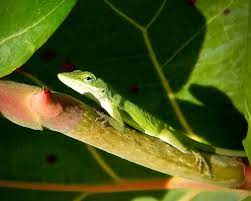

In [28]:
from IPython.display import Image
Image(filename='data/MobileNet-samples/1.JPG', width=300,height=200) 

We're going to process this image by passing it to our prepare_image() function and assign the result to this preprocessed_image variable. We're then having MobileNet predict on this image by calling mobile.predict() and passing it our preprocessed_image.



In [29]:
preprocessed_image = prepare_image('1.JPG')
predictions = mobile.predict(preprocessed_image)

Then, we're using an ImageNet utility function provided by Keras called decode_predictions(). It returns the top five ImageNet class predictions with the ImageNet class ID, the class label, and the probability. With this, we'll be able to see the five ImageNet classes with the highest prediction probabilities from our model on this given image. Recall that there are 1000 total ImageNet classes.


In [30]:
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01682714', 'American_chameleon', 0.5295184),
  ('n01739381', 'vine_snake', 0.11185168),
  ('n01644373', 'tree_frog', 0.09176177),
  ('n01694178', 'African_chameleon', 0.08664132),
  ('n01689811', 'alligator_lizard', 0.069202825)]]

Checking out the results, we have American_chameleon with 89%, then green_lizard at 10%, agama at 0.002%, and a couple other types of lizards at less than 000.1%.


In [31]:
# assert results[0][0][1] == 'American_chameleon'
results[0][0]

('n01682714', 'American_chameleon', 0.5295184)


The lizard in the image is actually an American chameleon, so the model did well at assigning that class the highest probability. The remaining four classes are all different types of similar lizards as well, so overall I'd say the model did a good job at classifying this one.











#### MobileNet Espresso Prediction
Let's do another prediction, this time on this delicious looking cup of espresso.


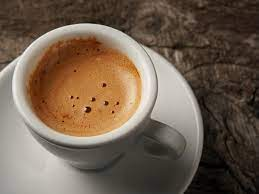

In [32]:
Image(filename='data/MobileNet-samples/2.JPG', width=300,height=200)

We're using the exact same code as we used for the lizard, except we're just now pointing to the image of the espresso.


In [33]:
preprocessed_image = prepare_image('2.JPG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n07920052', 'espresso', 0.92024666),
  ('n07584110', 'consomme', 0.051907755),
  ('n07932039', 'eggnog', 0.022178907),
  ('n07930864', 'cup', 0.0032384943),
  ('n07717556', 'butternut_squash', 0.00040807802)]]

The results for this one are spectacular.


The model assigned a 92.02% probability to the image being espresso, and the remaining four classes with the next highest probabilities are all reasonable as well, with cup, eggnog, consomme, and butternut_squash.

#### MobileNet Strawberry Prediction
Let's check out another one. This time we'll be passing an image of a strawberry.



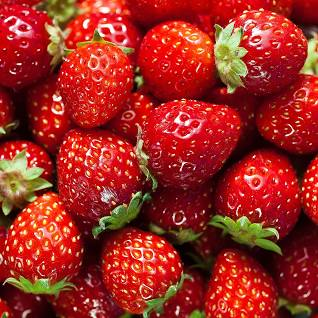

In [34]:
Image(filename='data/MobileNet-samples/3.JPG', width=300,height=200)

In [35]:
#Same code, new image.
preprocessed_image = prepare_image('3.JPG')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n07745940', 'strawberry', 0.98692596),
  ('n03887697', 'paper_towel', 0.0024094654),
  ('n07768694', 'pomegranate', 0.0017378611),
  ('n03729826', 'matchstick', 0.0015593411),
  ('n03461385', 'grocery_store', 0.0013713673)]]

Viewing the results, we have another extremely good prediction with a 98.69% probability being assigned to strawberry.

We can see that MobileNet is doing a great job at classifying images right out of the box. We'll be continuing to work with Now we'll see how we can fine-tune the model and use transfer learning on a new data set.


### Process Images for Fine-Tuned MobileNet with Keras

We'll be building on what we've learned about MobileNet to prepare and process our own custom image data set of sign language digits. These images will be later used to train our fine-tuned MobileNet model.


#### Obtain The Data
The new data set we'll be working with now does not have classes that were included in ImageNet, nor very similar to the ImageNet classes that MobileNet was originally trained on. We'll later go through the process together for tuning the model to predict on this new data.

This data set contains images of sign language digits. There are ten classes, labeled as 0 through 9, and each class is made up of images of hands showing the sign for that particular digit.
![Javatpoint](https://deeplizard.com/assets/jpg/e6502f1c.jpg)  

Each class has between 204 and 208 samples. The total data set contains 2062 samples.

This data set is available as grayscale images on Kaggle and is also available as RGB images on [Github](https://github.com/ardamavi/Sign-Language-Digits-Dataset). We'll be using the RGB data set.

#### Organize The Data
Before we can begin tuning the model, we first need to organize our images on disk. They will be organized in the same fashion as the cat and dog data set.

With code, we'll create the directories for the train, validation, and test sets, organize the images into their respective classes of 0 through 9 on disk, and then shuffle the data set and split the images into train, validation, and test sets.

First, download the data and save to your-current-nb-directory/data/Sign-Language-Digits-Dataset. Extract sub-directories labeled 0 through 9 and nest these directories directly underneath the Sign-Language-Digits-Dataset directory.

Before using the script below to organize the data, be sure you have the imports brought in from earlier.

Note, the first two lines of code change directory into the relevant directory where the data is stored and then checks to ensure that the directory structure hasn't already been set up.

#### Organize data into train, valid, test dirs

In [36]:
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

First, we create train, valid, and test directories.

We then move all class directories (0 - 9) with their respective images from Sign-Language-Digits-Dataset into the train directory.

We then make class directories (0 - 9) for the valid and test data sets as well.

We then loop through each class directory in the train directory and randomly move 30 images from each class into the corresponding class directory in valid and 5 images from each class into the corresponding class directory in test.

Finally, we end by moving back into current notebook directory.

#### Process The Data
After our image data is all organized on disk, we need to create the directory iterators for the train, validation, and test sets in the exact same way as we did for the cat and dog data set that we previously used.

In [37]:
train_path = 'data/Sign-Language-Digits-Dataset/train'
valid_path = 'data/Sign-Language-Digits-Dataset/valid'
test_path = 'data/Sign-Language-Digits-Dataset/test'

In [38]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


Notice the preprocessing_function parameter we're supplying to ImageDataGenerator. We're setting this equal to <b>tf.keras.applications.mobilenet.preprocess_input</b>. This is going to do the necessary MobileNet preprocessing on the images (explained previously) obtained from flow_from_directory().

To flow_from directory(), we're passing in the path to the data set, the target_size to resize the images to, and the batch_size we're choosing to use for training. We do this exact same thing for all three data sets: train, validation, and test.

For test_batches, we're also supplying one additional parameter, shuffle=False, which causes the test dataset to not be shuffled, so that we can access the corresponding non-shuffled test labels to plot to a confusion matrix later.

In [39]:
assert train_batches.n  == 1712
assert valid_batches.n  == 300
assert test_batches.n  == 50
assert train_batches.num_classes  == valid_batches.num_classes== test_batches.num_classes ==10

The data has now been prepared and processed. Next, we'll move on to fine-tuning the model.

### Fine-Tuning MobileNet on Custom Data Set with Keras

#### Modify Model
 we'll be building on what we've learned about MobileNet combined with the techniques we've used for fine-tuning to fine-tune MobileNet for a custom image data set.

When we previously demonstrated the idea of fine-tuning, we used the cat and dog data set. We noted, however, that the ImageNet data set that MobileNet and VGG16 were originally trained on already included many breeds of different types of dogs and cats.

Since the model had already learned dog and cat features during its original training, we didn't have to do too much tuning for our model to easily perform well on classifying those images.

#### Build The Fine-Tuned Model
Now, we'll <b>download</b> the MobileNet model, and print a summary of it.


In [71]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32


Next, we're going to grab the output from the 6th to last layer of the model and store it in this variable x.(we are not ging to include these last 6 layers).

In [73]:
x = mobile.layers[-6].output
#aading an output layer to the prevoious 6 layers, stored in x 
output = Dense(units=10, activation='softmax')(x)

We'll be using this to build a new model. This new model will consist of the original MobileNet up to the 6 to last layer. We're not including the last 5 layers of the original MobileNet.
By looking at the summary of the original model, we can see that by not including the last 5 layers, we'll be including everything up to and including the last global_average_pooling layer.

Note that the amount of layers that we choose to cut off when you're fine-tuning a model will vary for each scenario, but I've found through experimentation that just removing the last 5 layers here works out well for this particular task. So with this setup, we'll be keeping the vast majority of the original MobileNet architecture, which has 88 layers total.

Now, we need to reshape our output from the global_average_pooling layer that we will pass to our output layer, which we're calling output. The output layer will just be a Dense layer with 10 output nodes for the ten corresponding classes, and we'll use the softmax activation function.

In [74]:
# x = tf.keras.layers.Reshape(target_shape=(1024,))(x)

Now, we construct the new fine-tuned model, which we're calling model.

In [75]:
#create the model using the input of the original model(mobile.input) and the output layer that we created
model = Model(inputs=mobile.input, outputs=output)

Note, you can see by the Model constructor used to create our model, that this is a model that is being created with the Keras Functional API, not the Sequential API. That's why this format that we're using to create the model may look a little different than what you're used to.

To build the new model, we create an instance of the Model class and specify the inputs to the model to be equal to the input of the original MobileNet, and then we define the outputs of the model to be equal to the output variable we created directly above.

This creates a new model, which is identical to the original MobileNet up to the original model's sixth to last layer. We don't have the last 6 original MobileNet layers included, but instead we have a new layer, the output layer we created with ten output nodes.

Now, we need to choose how many layers we actually want to be trained when we train on our new data set.

We still want to keep a lot of what the original MobileNet has already learned from ImageNet by freezing the weights in many of layers, especially earlier ones, but we do indeed need to train some layers since the model still needs to learn features about this new data set.

Training the last 23 layers will give us a pretty decently performing model.

In [76]:
#now we will freez all layers except for the last 23 layers
for layer in model.layers[:-23]:
    layer.trainable= False

In [77]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

Note that 23 is not necessarily the optimal number of layers to train. Play around with this some yourself and let me know in the comments if you can get better results by training more or less layers than the results we'll see in a few minutes.

So the twenty-third-to-last layer and all layers after it will be trained when we fit the model on the new data set. All layers above will not be trained, so their original ImageNet weights will stay in place.

Looking at the model summary now, we can see the new model architecture, along with how the number of trainable parameters has changed from the original model.

#### Train The Model
Now, we compile the model in the same way as we've done with other models in this course.

In [78]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Similarly, we call fit() to train the model in the same fashion as we've done for other models.


In [79]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=10,
            verbose=2
)

Epoch 1/10
172/172 - 28s - loss: 0.6304 - accuracy: 0.8207 - val_loss: 0.3026 - val_accuracy: 0.9233
Epoch 2/10
172/172 - 14s - loss: 0.1173 - accuracy: 0.9807 - val_loss: 0.1654 - val_accuracy: 0.9667
Epoch 3/10
172/172 - 15s - loss: 0.0521 - accuracy: 0.9930 - val_loss: 0.1013 - val_accuracy: 0.9800
Epoch 4/10
172/172 - 15s - loss: 0.0318 - accuracy: 0.9971 - val_loss: 0.0791 - val_accuracy: 0.9867
Epoch 5/10
172/172 - 14s - loss: 0.0259 - accuracy: 0.9982 - val_loss: 0.0922 - val_accuracy: 0.9867
Epoch 6/10
172/172 - 14s - loss: 0.0200 - accuracy: 0.9971 - val_loss: 0.1011 - val_accuracy: 0.9867
Epoch 7/10
172/172 - 15s - loss: 0.0152 - accuracy: 0.9988 - val_loss: 0.0822 - val_accuracy: 0.9833
Epoch 8/10
172/172 - 15s - loss: 0.0175 - accuracy: 0.9959 - val_loss: 0.0768 - val_accuracy: 0.9867
Epoch 9/10
172/172 - 15s - loss: 0.0129 - accuracy: 0.9988 - val_loss: 0.1026 - val_accuracy: 0.9800
Epoch 10/10
172/172 - 15s - loss: 0.0226 - accuracy: 0.9942 - val_loss: 0.0965 - val_accura

Looking at the output, the results are pretty good.


The accuracy on the training set has reached 100% pretty early in the training. Our validation accuracy is lagging some, only at 90%, so we have a little overfitting going on here, but we can see that it had not stalled out by the time we reached our last epoch.

Perhaps running more epochs will yield better results.

#### Use The Model For Inference

We set up our test_labels by grabbing the classes from our unshuffled test set.


In [80]:
test_labels = test_batches.classes

We use model.predict() to run the predictions in the same fashion as we've used this function.

In [81]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

We then create a confusion_matrix object using scikit-learn's confusion_matrix.


In [82]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

We now bring in the same plot_confusion_matrix function from scikit-learn that we've used in the past to plot the confusion matrix.


In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Now we're just printing the class_indices from our test_batches so that we can see the order of the classes and specify them in that same order when we create the labels for our confusion matrix.

In [84]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

After creating the labels, we then plot our confusion matrix

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 1 0 4 0 0 0]
 [0 0 0 0 0 0 0 4 1 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


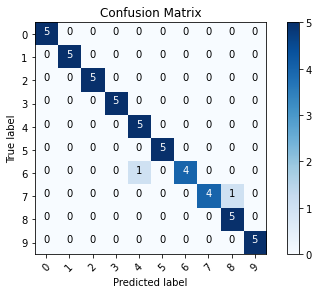

In [85]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


######  Let's check out the results.

Looking pretty good! Just checking out the diagonal in blue that contains all the correctly predicted samples, we can get an idea that the model did pretty well. Each class had 5 samples, and we see a decent amount of 5s here.

Total, the model gave five incorrect predictions out of fifty total, which gives us an accuracy of 90% on the test set. Not bad. As mentioned earlier, there are still improvements that could be made to this model, so if you implement any and get better than 90% accuracy on the test set, share in the comments!

### Data Augmentation with Keras

In our case, the data we'll work with will be images. For image data specifically, data augmentation could consist of things like flipping the image horizontally or vertically, rotating the image, zooming in or out, cropping, or varying the color.

#### Why Do We Need Data Augmentation?
For starters, it will help us obtain more data for training. Maybe we have a small training set, or maybe we just want to make our training set larger. We can do that by augmenting our existing data and then adding that data to the training set.

Another reason to use data augmentation is to reduce overfitting.

#### Performing Data Augmentation In Code
Let's now see how we can perform data augmentation using Keras.

First, we import all the libraries we'll be using.

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Next, we'll use this plotImages() function obtained from TensorFlow's documentation to plot the processed images within our Jupyter notebook.

In [87]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

We'll now define this variable called gen as an <b>ImageDataGenerator</b>. All the parameters being passed are the different ways we're telling Keras to augment the image.

In [88]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

Check out the documentation to understand the units used for each augmentation technique we've specified. For example, rotation_range is measured in degrees, while width_shift_range is measured as a fraction of the width of the image.

Next, we choose a random image of a dog from disk.

In [100]:
chosen_image = random.choice(os.listdir('data/dogs-vs-cats/train/dog'))

We then create a variable called image_path and set that to the relative location on disk of the chosen image.

In [101]:
image_path = 'data/dogs-vs-cats/train/dog/' + chosen_image

Note, to follow along, you will need to point to a valid location and image file on your machine.

Next, we'll obtain the image by reading the image from disk by using plt.imread() and passing in the image_path. We also, expand the dimensions so that the image is compatible for how we'll use it later.

In [102]:
image = np.expand_dims(plt.imread(image_path),0)

Now, we'll plot the image just to see what the original image looks like.

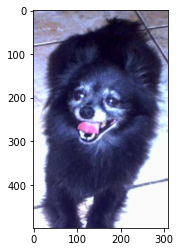

In [103]:
plt.imshow(image[0])

Note, to follow along, you will need to point to a valid location and image file on your machine.
Next, we'll obtain the image by reading the image from disk by using plt.imread() and passing in the image_path. We also, expand the dimensions so that the image is compatible for how we'll use it later.

Next, we'll generate batches of augmented images from the original image.



In [104]:
aug_iter = gen.flow(image)

The flow() function takes numpy data and generates batches of augmented data.

Now we'll get 10 samples of the augmented images.



In [105]:
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

Now we'll plot the augmented images.

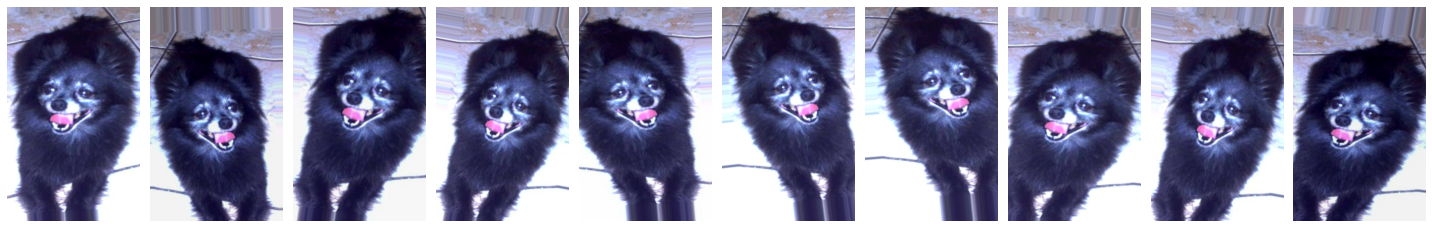

In [106]:
plotImages(aug_images)

These are ten images that have been augmented from the original image according to the parameters we passed to the ImageDataGenerator earlier.

We can see that some of the images have been flipped horizontally, some have slight color variation, some are tilted slightly to the left or right, and some are shifted down or up slightly.

#### Save Augmented Data
Note, if you'd like to save these images so that you can add them to your training set, then to gen.flow(), you should also specify the parameter save_to_dir and set it equal to a valid location on disk.

You can optionally specify a prefix for which to prepend to file names of the saved augmented images, as well as optionally specify the file type as 'png' or 'jpeg' images. 'png' is the default.

In [107]:
aug_iter = gen.flow(image, save_to_dir='data/dogs-vs-cats/train/dog', save_prefix='aug-image-', save_format='jpeg')

Note, you can also use <b>ImageDataGenerator.flow_from_directory()</b> as opposed to <b>ImageDataGenerator.flow()</b> if you're wanting to generate batches of augmented data from data saved to an organized directory structure on disk.

Hopefully now you understand what data augmentation is, why you'd want to use it, and how you can make use of it in Keras.